In [1]:
import os
import io
import s3fs
import pandas as pd
import numpy as np
import seaborn as sns

!pip install missingno
import missingno as msno

!pip install nltk
import nltk as nltk

%matplotlib inline

#fichier projet
from bdd import *

Looking in indexes: https://nexus.beta.innovation.insee.eu/repository/pypi-public/simple
Looking in indexes: https://nexus.beta.innovation.insee.eu/repository/pypi-public/simple


Objectif : On essaye de reconcilier l'adresse de l'employeur d'un BI (Bulletin Individuel) au siret/siren contenu dans SICOR :

>Le numéro SIREN correspond à une série unique de 9 chiffres, attribuée par l’INSEE à chaque entreprise. Le numéro SIRET >correspond au numéro SIREN suivi de 5 chiffres correspondant à un Numéro Interne de Classement (NIC) propre à chaque >établissement de l’entreprise. Celle-ci aura un numéro SIREN et autant de NIC que d’établissements différents, c’est-à-dire un >seul numéro SIREN  et autant de SIRET que d’établissements/lieux d’exercice de son activité. Le numéro SIREN SIRET est mentionné >sur le Kbis (appelé « K » pour une entreprise individuelle), document officiel obtenu après l’immatriculation de l’entreprise et >attestant de sa légalité.



# 1 Etudions un BI

In [7]:
table_name = 'rp_final_2014'
my_driver = PostGre_SQL_DB()
df_rp2014 = my_driver.read_from_table('rp_final_2014')

In [8]:
print('nb lines : {}'.format(len(df_rp2014)))
df_rp2014.head()

nb lines : 30876


,cabbi,typcol,depcom_code,rs_x,ilt_x,vardompart_x,numvoi_x,bister_x,typevoi_x,nomvoi_x,...,naf2,pct2,naf3,pct3,naf4,pct4,naf5,pct5,nbtot,nb5
0,4300038348,0.0,05149,ROSTAN GAP,2,None,None,None,None,None,...,4322A,27.0,*****,NaN,*****,NaN,*****,NaN,11.0,11.0
1,4300038770,0.0,83005,JAEGGI,1,2,None,None,None,None,...,None,NaN,None,NaN,None,NaN,None,NaN,None,None
2,4300039414,0.0,04122,LYCE PGDG DIGNE,2,None,None,None,None,ZI SAINT CHRISTOPHE,...,8520Z,19.0,8532Z,12.0,*****,NaN,*****,NaN,63967.0,59923.0
3,4300039800,0.0,83006,MAIRIE D'AIX,2,None,0012,None,R,PIERRE ET MARIE CURIE,...,*****,NaN,*****,NaN,*****,NaN,*****,NaN,9602.0,7477.0
4,4300041695,0.0,04148,CNRS,2,None,0023,None,R,DES DIABLES BLEUS,...,7220Z,34.0,*****,NaN,*****,NaN,*****,NaN,4219.0,3821.0


In [9]:
df_rp2014.dtypes

cabbi                  object
typcol                float64
depcom_code            object
rs_x                   object
ilt_x                  object
vardompart_x           object
numvoi_x               object
bister_x               object
typevoi_x              object
nomvoi_x               object
cpladr_x               object
actet_x                object
actet_c_c              object
actet_c                object
clt_c_c                object
clt_x                  object
dlt_x                  object
plt_x                  object
siretc                 object
note_mca_adr_c        float64
note_mca_nom_c        float64
i_mca_c                object
profi_x                object
profs_x                object
profa_x                object
i_reprise_act          object
i_siret_m             float64
siret_dec              object
siretm                 object
proces_codage_init     object
arbitrage              object
siretq                 object
i_siret_q              object
siret_arb 

#CABBI est supposé être l'identifiant, pas de doublons  
Toutes les variables contenant un '_x' sont les variables déclarés

In [10]:
df_declaration = df_rp2014.loc[:, df_rp2014.columns.str.contains('_x')]
print(df_declaration.columns)

Index(['rs_x', 'ilt_x', 'vardompart_x', 'numvoi_x', 'bister_x', 'typevoi_x',
       'nomvoi_x', 'cpladr_x', 'actet_x', 'clt_x', 'dlt_x', 'plt_x', 'profi_x',
       'profs_x', 'profa_x'],
      dtype='object')


In [11]:
df_declaration.head()

,rs_x,ilt_x,vardompart_x,numvoi_x,bister_x,typevoi_x,nomvoi_x,cpladr_x,actet_x,clt_x,dlt_x,plt_x,profi_x,profs_x,profa_x
0,ROSTAN GAP,2,None,None,None,None,None,None,REPARATION D APPAREILS ELECTRIQUE,GAP,05,None,None,OUVRIER QUALIFIE,None
1,JAEGGI,1,2,None,None,None,None,None,EXPL AGRICOLE OLEICULTURE,None,None,None,AGRICULTRICE,None,None
2,LYCE PGDG DIGNE,2,None,None,None,None,ZI SAINT CHRISTOPHE,None,ENSEIGNEMENT,DIGNE LES BAINS,04,None,None,PROFESSEUR AGREGE,None
3,MAIRIE D'AIX,2,None,0012,None,R,PIERRE ET MARIE CURIE,None,SERVICE PUBLIC,AIX EN PROVENCE,13,None,None,AGENT DE MAITRISE PRINCIPALE,None
4,CNRS,2,None,0023,None,R,DES DIABLES BLEUS,None,RECHERCHE,NICE,None,None,None,CHERCHEUR,None


In [12]:
df_declaration.isna().sum()

rs_x              342
ilt_x            2078
vardompart_x    27417
numvoi_x        20788
bister_x        30496
typevoi_x       15131
nomvoi_x         8645
cpladr_x        30169
actet_x          2090
clt_x           11188
dlt_x           13605
plt_x           30841
profi_x         27930
profs_x          4877
profa_x         29282
dtype: int64

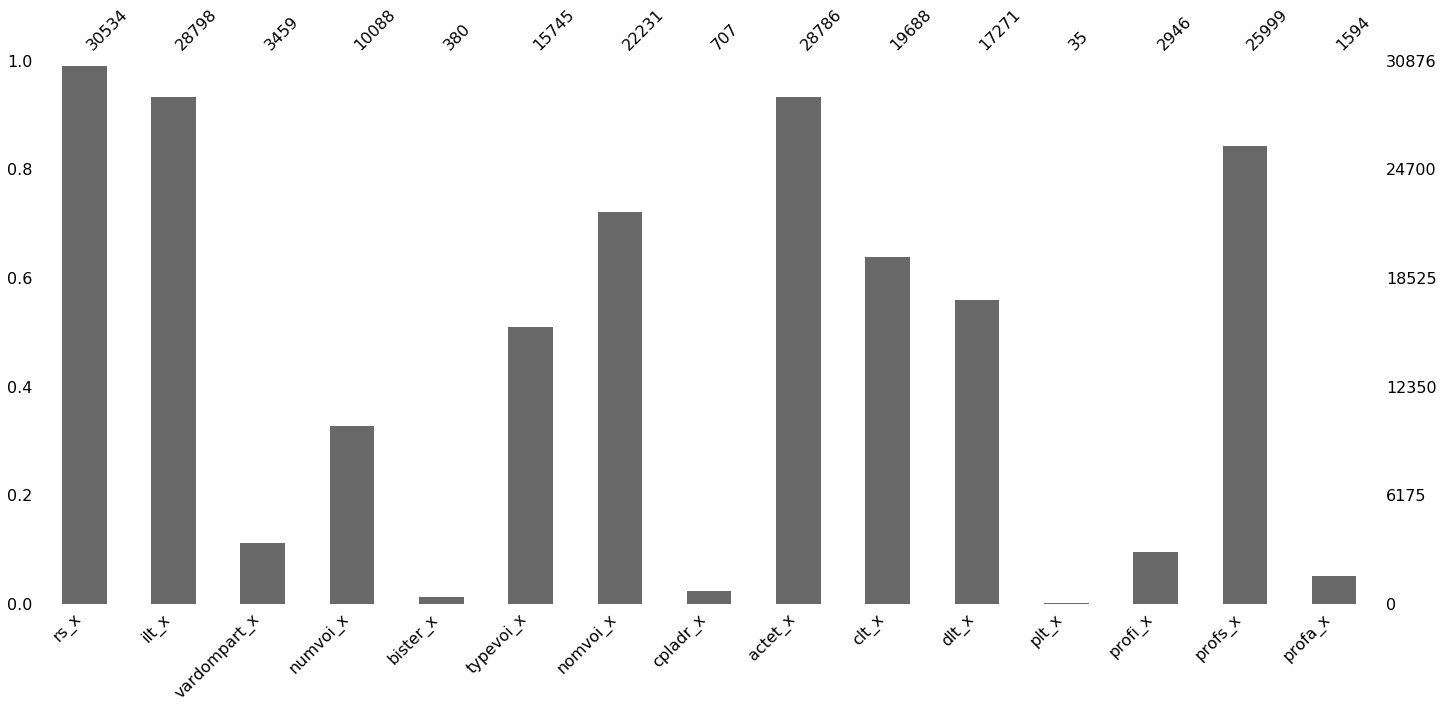

In [13]:
msno.bar(df_declaration)

Sur cet échantillon, le champs rs_x qui correspond au nom de l'établissement est quasi 100%.   
Actet_x activité économique aussi.   
~75% sur la localisation de l'entreprise

## 1.2 Score MCA

| Var |  nature | desc | commentaire
:-: |:-: | :-: | :-:
|SIRET_DEC | Calculée|Établissement de travail|Siret finalement conservé|  
|SIRETC|Codée|Établissement de travail codé automatiquement (siret)|Siret codé par MCA|  
|SIRETM|Codée|Établissement de travail en cours de codage manuel (siret)|Siret codé  par le gestionnaire|  


l'idée est d'exploré les scores MCA selon les catégories C, D et E et de voir si on peux les discriminer

In [14]:
df_label = df_rp2014[['siret_dec','siretc','siretm','note_mca_adr_c','note_mca_nom_c','i_mca_c']]

In [15]:
df_label.head()

,siret_dec,siretc,siretm,note_mca_adr_c,note_mca_nom_c,i_mca_c
0,41056845500019,42826802326353,41056845500019,31.0,333.0,E
1,40326325400027,40326325400027,40326325400027,31.0,461.0,E
2,19040490500019,26040358900013,19040490500019,22.0,384.0,E
3,21130001700012,21130001700012,21130001700012,31.0,555.0,E
4,18008901303324,18008901303324,18008901303324,31.0,800.0,E


On regarde le % de siret mca directement approuvé

In [16]:
df_label.dtypes

siret_dec          object
siretc             object
siretm             object
note_mca_adr_c    float64
note_mca_nom_c    float64
i_mca_c            object
dtype: object

In [17]:
#perf MCA (1ère instance)
len(df_label[df_label.siret_dec == df_label.siretc]) / len(df_rp2014)

0.43901412100012954

On regarde le % de siret approuvé par un gestionnaire, n'est pas exclusif au MCA

In [18]:
#perf gestionnaire (si ça se passe mal)
len(df_label[df_label.siret_dec == df_label.siretm]) / len(df_rp2014)

0.9362935613421428

In [19]:
df_label.isna().sum()

siret_dec            0
siretc            5787
siretm            1967
note_mca_adr_c    5787
note_mca_nom_c    5787
i_mca_c           5787
dtype: int64

In [20]:
#check si on a score MCA sans siret MCA (pas possible normalement)
#garde-fou
df_label[(df_label.siretc.isnull()) & (~df_label.note_mca_adr_c.isnull())]

,siret_dec,siretc,siretm,note_mca_adr_c,note_mca_nom_c,i_mca_c


In [21]:
df_label[(df_label.siretc.isnull()) & (~df_label.note_mca_nom_c.isnull())]

,siret_dec,siretc,siretm,note_mca_adr_c,note_mca_nom_c,i_mca_c


In [22]:
df_rp2014.i_mca_c.value_counts(dropna=False)

E      21759
NaN     5787
D       2341
C        989
Name: i_mca_c, dtype: int64

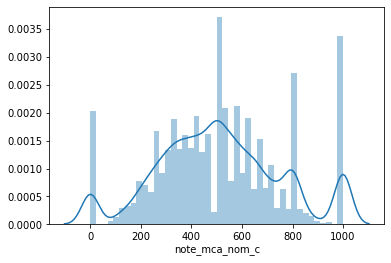

In [23]:
sns.distplot(df_label[df_label.note_mca_nom_c.notna()].note_mca_nom_c)

Valeur allant de 0 à 1000

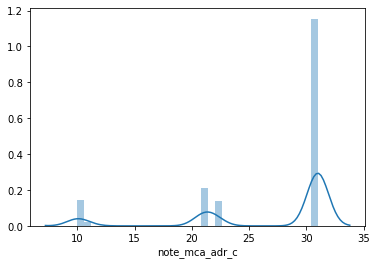

In [24]:
sns.distplot(df_label[df_label.note_mca_adr_c.notna()].note_mca_adr_c)

Distribution plus étrange des note adr

In [25]:
df_label['mca_approved'] = 0
df_label.mca_approved = df_label.apply(lambda x: 1 if x.siret_dec == x.siretc else 0, axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


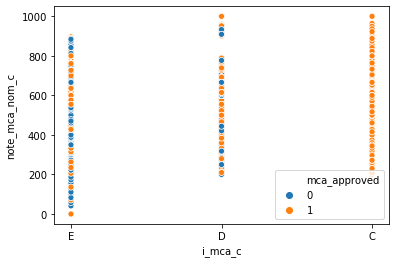

In [26]:
ax = sns.scatterplot(x="i_mca_c", y="note_mca_nom_c",hue="mca_approved", data=df_label)

On essaye de voir si les classe E, D et C ont une distribution particulière de score. MCA_approved signifie que l'echo mca a été approuvé (la distribution C est ceux qui sont passé en 1ère passe, logique de retrouvé 100% de mca_approved). La distribution D semble un peu plus haute.

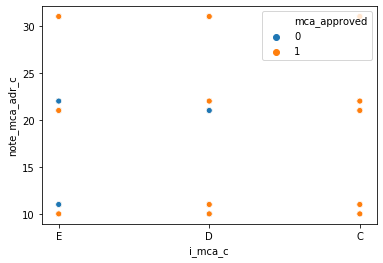

In [27]:
ax = sns.scatterplot(x="i_mca_c", y="note_mca_adr_c",hue="mca_approved", data=df_label)

mca_adr contenant moins de valeur potentielle, le graphique est moins lisible.

In [28]:
df_C_decl = df_rp2014[df_rp2014.i_mca_c == 'C']
df_C_decl_declaration = df_C_decl.loc[:, df_C_decl.columns.str.contains('_x')]

On va regarder les distribution de valeurs manquante en fonctione de la classe C, D et E

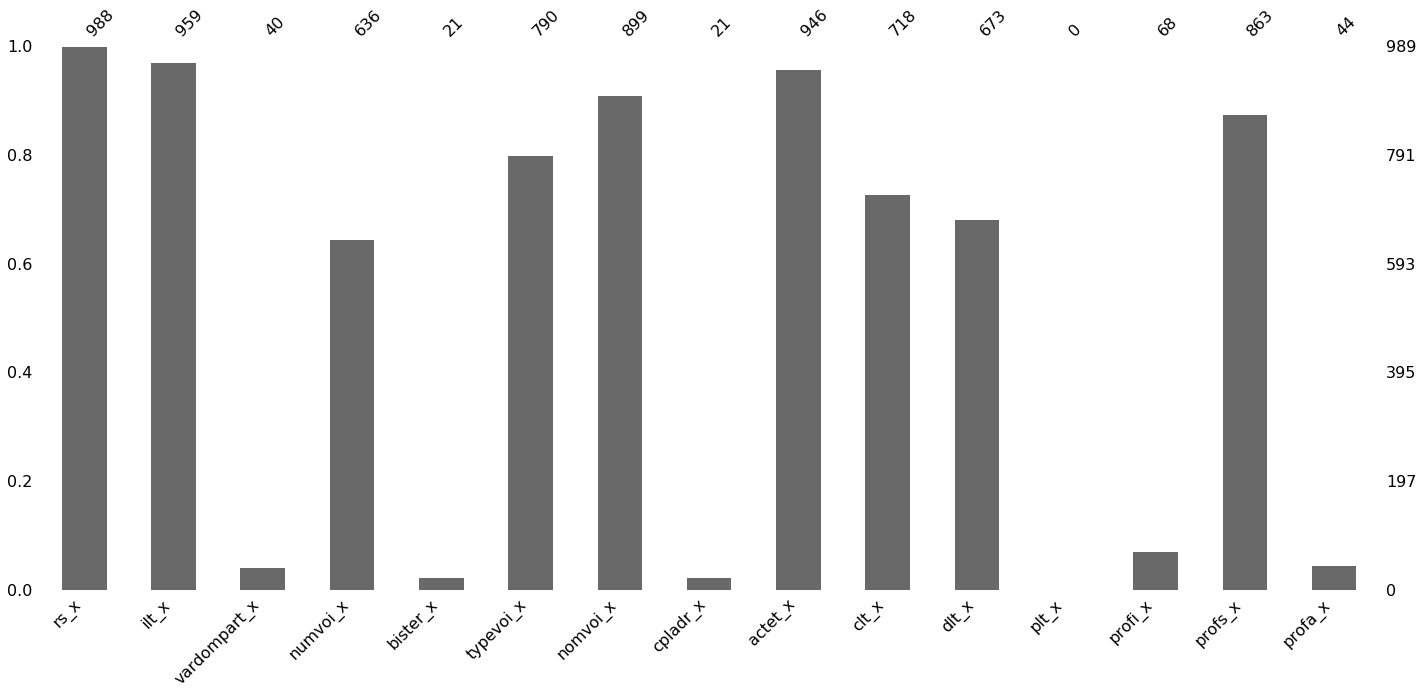

In [29]:
msno.bar(df_C_decl_declaration)

In [30]:
df_D_decl = df_rp2014[df_rp2014.i_mca_c == 'D']
df_D_decl_declaration = df_D_decl.loc[:, df_D_decl.columns.str.contains('_x')]

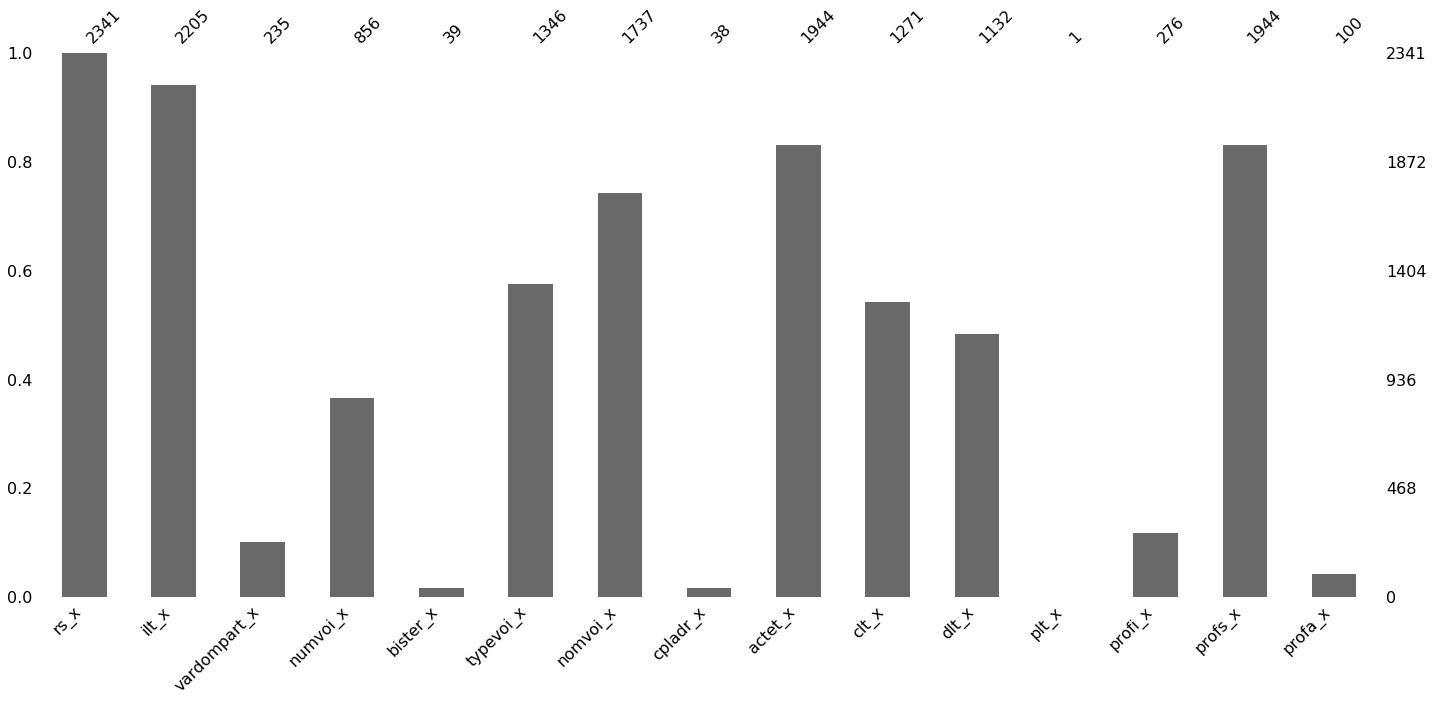

In [31]:
msno.bar(df_D_decl_declaration)

In [32]:
df_E_decl = df_rp2014[df_rp2014.i_mca_c == 'E']
df_E_decl_declaration = df_E_decl.loc[:, df_E_decl.columns.str.contains('_x')]

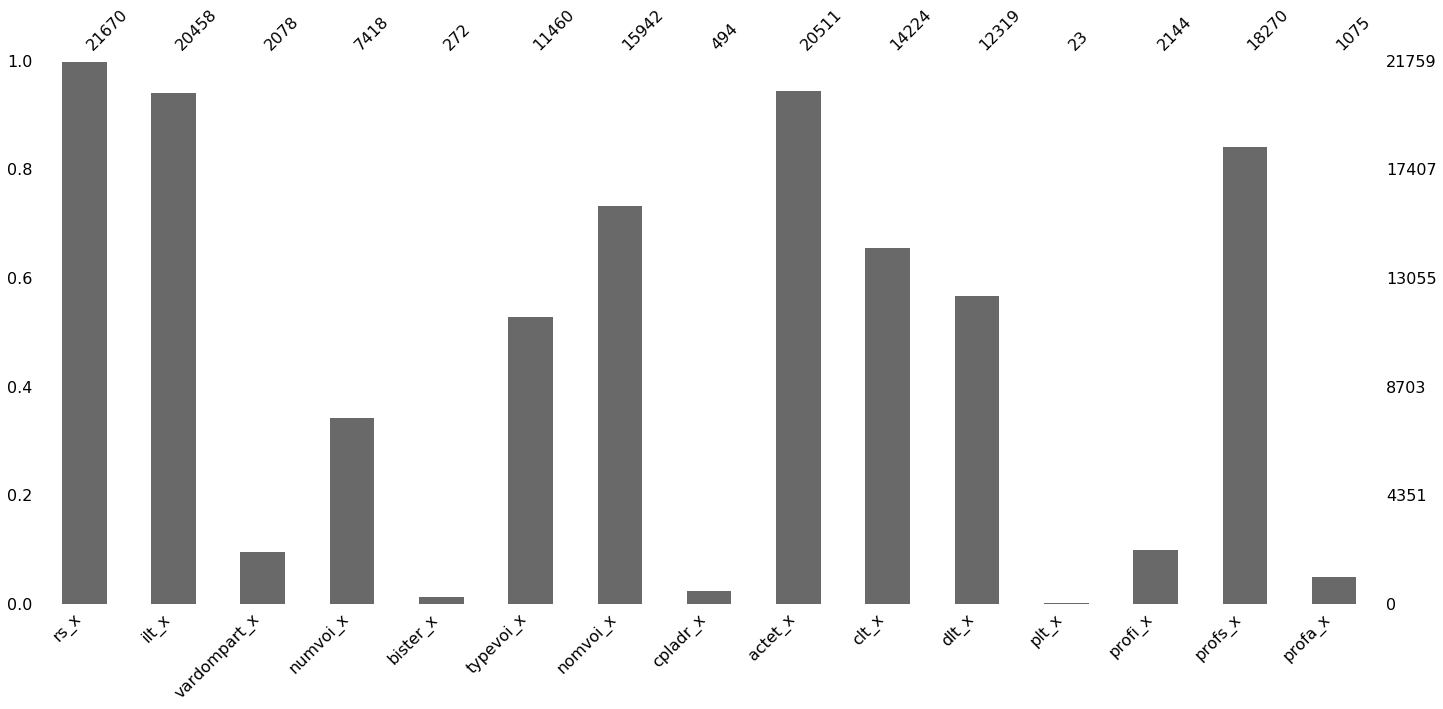

In [33]:
msno.bar(df_E_decl_declaration)

### 1.2 Profession
On veut voir si certaines profession sont plus difficile à traiter que d'autre (toujours selon les classe C D et E)

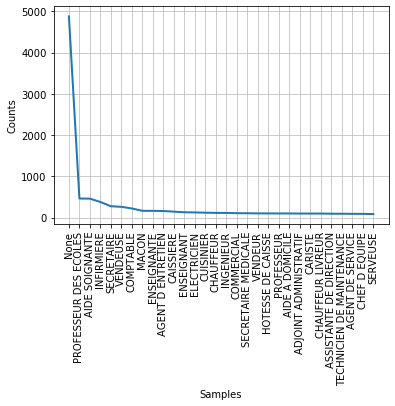

In [34]:
nltk.FreqDist(df_rp2014.profs_x.values).plot(30)

In [35]:
df_C_decl_declaration.profs_x.value_counts()

VENDEUSE                                12
COMPTABLE                               11
ASSISTANTE DE DIRECTION                  9
CHEF D EQUIPE                            7
CHAUFFEUR LIVREUR                        7
                                        ..
ASSISTANTE ADMINISTRATION DES VENTES     1
ANALYSTE RISQUE DE MARCHE                1
APPRENTI COMMERCE INTERNATIONAL          1
ASSISTANTE DE LANGUE PORTUGAISE          1
DIRECTEUR DE SITE                        1
Name: profs_x, Length: 661, dtype: int64

In [36]:
df_D_decl_declaration.profs_x.value_counts()

AIDE SOIGNANTE                               78
INFIRMIERE                                   71
SECRETAIRE                                   27
SECRETAIRE MEDICALE                          26
ADJOINT ADMINISTRATIF                        24
                                             ..
ASSISTANTE MATERNELLE EN CRECHE               1
ANIMATRICE CENTRE SOCIAL                      1
CHEF DE CUISINE AGENT DE MAITRISE             1
BOULANGER EN FORMATION                        1
ENTRETIEN LE COLLEGE ESPACE VERT PEINTURE     1
Name: profs_x, Length: 1201, dtype: int64

In [37]:
df_E_decl_declaration.profs_x.value_counts()

PROFESSEUR DES ECOLES                                 339
AIDE SOIGNANTE                                        329
INFIRMIERE                                            266
SECRETAIRE                                            207
VENDEUSE                                              191
                                                     ... 
SECRETAIRE ADJOINT ADMINISTRATIF 1 ERE CLASSE           1
AGENT HOSPITALIER SCE                                   1
INFORMATICIEN GESTION EN PRESTATARIAT                   1
CONSEILLER D ORIENTATION PSYCHOLOGUE                    1
CHEF D EQUIPE EN REPARATION CARROSSERIE AUTOMOBILE      1
Name: profs_x, Length: 7946, dtype: int64

professeur des écoles est singulier

In [38]:
df_rp2014[df_rp2014.profs_x == "PROFESSEUR DES ECOLES"].groupby('i_mca_c').count()

,cabbi,typcol,depcom_code,rs_x,ilt_x,vardompart_x,numvoi_x,bister_x,typevoi_x,nomvoi_x,...,naf2,pct2,naf3,pct3,naf4,pct4,naf5,pct5,nbtot,nb5
i_mca_c,,,,,,,,,,,,,,,,,,,,,
C,2,2,2,2,2,0,2,0,2,2,...,2,2,2,2,2,0,2,0,2,2
D,3,3,3,3,3,0,1,0,1,2,...,3,2,3,1,3,0,3,0,3,3
E,339,339,339,339,327,5,174,7,261,312,...,311,284,311,225,311,18,311,0,311,311


In [39]:
#problème avec la wildcard '_' avec le renommage, obliger de couper en 2 étape sinon il ne trouve pas la colonne 'count' qui est toujours en '0'
a = df_rp2014[['profs_x','i_mca_c']].groupby(['profs_x','i_mca_c']).size().reset_index()
a.rename(columns={a.columns[-1]:'count'},inplace=True)
b= a.pivot(index='profs_x',columns='i_mca_c',values='count').fillna(0)

In [40]:
#Tableau plus pratique à manipuler si on veut les fréquence de profession selon une classe
b.sort_values(by=['E'],ascending=False)

i_mca_c,C,D,E
profs_x,,,
PROFESSEUR DES ECOLES,2.0,3.0,339.0
AIDE SOIGNANTE,7.0,78.0,329.0
INFIRMIERE,5.0,71.0,266.0
SECRETAIRE,6.0,27.0,207.0
VENDEUSE,12.0,7.0,191.0
...,...,...,...
OPQ CONTRACTUEL CHOMEUR AGENT DE SALUBRITE (POUBELLE),0.0,1.0,0.0
AIDE SOIGNANTE GRADE CLASSE NORMALE E4 ECHELON 4,0.0,1.0,0.0
RESPONSABLE IMPORT EXPORT,1.0,0.0,0.0


In [41]:
df_rp2014.profs_x.value_counts()

PROFESSEUR DES ECOLES                      462
AIDE SOIGNANTE                             459
INFIRMIERE                                 378
SECRETAIRE                                 275
VENDEUSE                                   261
                                          ... 
CONTROLEUR DE MARCHANDISES ALIMENTAIRES      1
ATTACHE                                      1
TECH LABO                                    1
MANAGER D UNIVERS MARCHAND                   1
AGENT DE TRANSIT COMMERCIALE POLYVALENT      1
Name: profs_x, Length: 10646, dtype: int64

## 1.3 Nom Etablissement travail

In [42]:
df_rp2014.rs_x.value_counts(dropna=False)

EDUCATION NATIONALE                   1041
SNCF                                   350
NaN                                    342
MAIRIE                                 160
MINISTERE DE L'INTERIEUR               141
                                      ... 
PSA . AUTOMOBILE PEUGEOT                 1
CABS SERVICES                            1
COMPAGNIE NATIONALE DU RHONE             1
CENTRE HOSPITALIER DINAN                 1
CNPE SAINT - ALBAN / SAINT MAURICE       1
Name: rs_x, Length: 23143, dtype: int64

In [43]:
#set(df_rp2014.rs_x.values)

In [44]:
my_text  = df_rp2014.rs_x.values

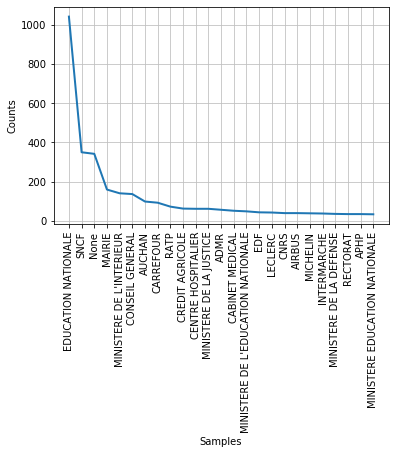

In [45]:
nltk.FreqDist(my_text).plot(25)